In [1]:
from portfolioOptimization import Portfolio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from yahoo_historical import Fetcher

In [2]:
def download_price_df(stock_list, start_date="2009-01-01", end_date="2019-09-30"):
    # date_parse function for Fetcher
    def dateparse(date): return [int(x) for x in date.split('-')]
    start_date = dateparse(start_date)
    end_date = dateparse(end_date)

    # initiate data list
    df_all = []

    # call API to obtain data
    for stock in stock_list:
        try:
            df = Fetcher(stock, start=start_date, end=end_date).getHistorical()
            df = df.reset_index()
            df['stock_code'] = stock
            df_all.append(df)
        except:
            print(stock + " not available")

    # concate data list and convert to pandas dataframe
    df = pd.concat(df_all, ignore_index=True, sort=False)

    # Data Wrangling
    df = df[['Date', 'Adj Close', 'stock_code']]
    df = df.set_index('Date')

    # filter out small trading day stocks (this is to avoid using some stocks which got unlisted during the period)
    small_trading_day_stock = df.groupby('stock_code').size()[
        df.groupby('stock_code').size() < 1000].index
    df = df[~df['stock_code'].isin(small_trading_day_stock)]
    df = df.pivot(columns='stock_code')
    df.columns = df.columns.droplevel()

    return df

In [3]:
# Create HSI stock list (20141231)
stock_list = ["0005.HK", "1299.HK", "0939.HK", "1398.HK", "3988.HK",
              "0388.HK", "2628.HK", "2318.HK", "0011.HK", "2388.HK",
              "3328.HK", "0023.HK", "0002.HK", "0003.HK", "0006.HK",
              "0836.HK", "0001.HK", "0016.HK", "0688.HK", "0004.HK",
              "0101.HK", "0012.HK", "0017.HK", "0083.HK", "1109.HK",
              "0700.HK", "0941.HK", "0883.HK", "0857.HK", "0013.HK",
              "0386.HK", "0027.HK", "1928.HK", "1088.HK", "0151.HK",
              "0762.HK", "1044.HK", "0992.HK", "0019.HK", "0494.HK",
              "2319.HK", "1880.HK", "0322.HK", "0066.HK", "0135.HK",
              "0144.HK", "0291.HK", "0267.HK", "1199.HK", "0293.HK"]

In [4]:
# download df data
df = download_price_df(
    stock_list, start_date="2009-01-01", end_date="2019-09-30")

In [5]:
# export df data
# df.to_excel('df_data.xlsx')

In [6]:
# import from excel
# df = pd.read_excel('df_data.xlsx', index_col='Date')
# df.index = pd.to_datetime(df.index)

In [7]:
# Split train test
train_test_cutoff = '2015-01-01'
df_train = df.loc[:train_test_cutoff]
df_test = df.loc[train_test_cutoff:]

In [8]:
# Optimize
opt_list = ['min_var', 'min_abs_dev', 'min_max']
allocations = []
train_result = []
test_result = []
for opt_val in opt_list:
    opt = Portfolio(df_train).optimize(opt_val, min_return=0.2)
    allocations.append(opt.result['allocation'])
    allocation_value = opt.result['allocation'].values.reshape(-1,)
    train_result.append(pd.Series(
        Portfolio(df_train).portfolio_annualised_performance(allocation_value)))
    test_result.append(pd.Series(
        Portfolio(df_test).portfolio_annualised_performance(allocation_value)))
    
allocations = pd.concat(allocations, axis=1)
allocations.columns = opt_list

train_result = pd.concat(train_result, axis=1)
train_result.columns = opt_list

test_result = pd.concat(test_result, axis=1)
test_result.columns = opt_list

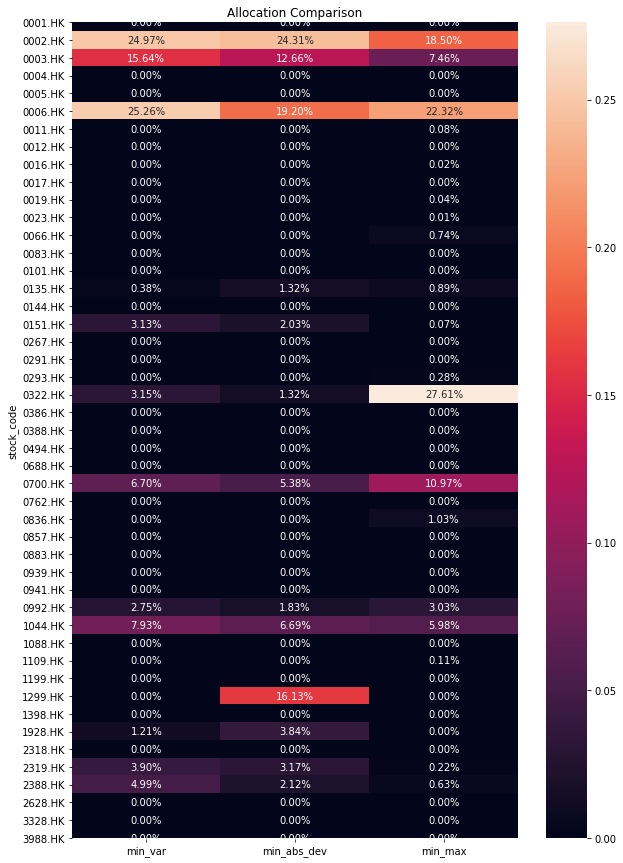

In [9]:
# Allocation plot
plt.figure(figsize=(10, 15))
sns.heatmap(allocations, annot=True, fmt=".2%")
plt.title('Allocation Comparison')
plt.show()

                 min_var  min_abs_dev   min_max
annaul_std      0.123149     0.130776  0.142390
annual_returns  0.200000     0.200000  0.200000
annual_abs_dev  1.498549     1.451412  1.737501
min_return     -0.029196    -0.035440 -0.022952
annual_sharpe   1.624053     1.529338  1.404591


<Figure size 720x720 with 0 Axes>

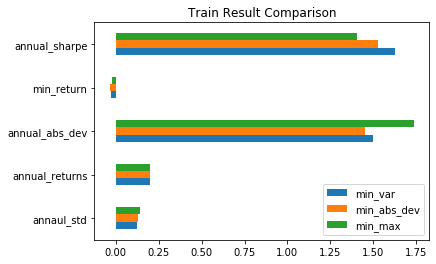

In [10]:
# Train result plot
plt.figure(figsize=(10, 10))
train_result.plot(kind='barh')
plt.title('Train Result Comparison')
print(train_result)
plt.show()

                 min_var  min_abs_dev   min_max
annaul_std      0.131649     0.138791  0.167737
annual_returns  0.065129     0.085107  0.050387
annual_abs_dev  1.532707     1.618355  1.982119
min_return     -0.041195    -0.042750 -0.058444
annual_sharpe   0.494717     0.613202  0.300393


<Figure size 720x720 with 0 Axes>

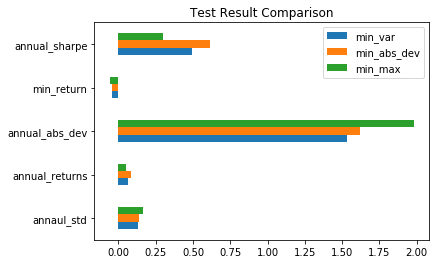

In [11]:
# Test result plot
plt.figure(figsize=(10, 10))
test_result.plot(kind='barh')
plt.title('Test Result Comparison')
print(test_result)
plt.show()

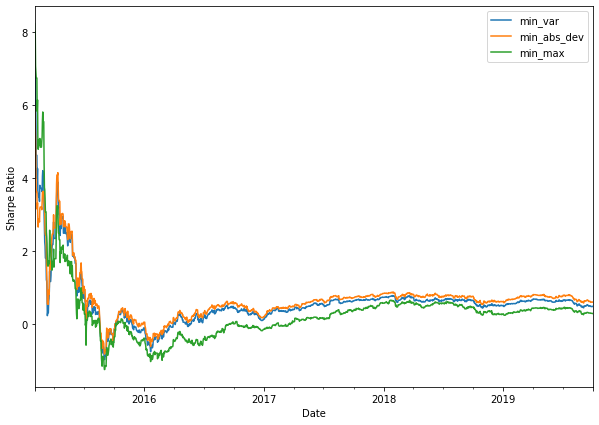

In [12]:
# Sharpe ratio by time in test set
date_list = [d.strftime('%Y-%m-%d')
             for d in pd.date_range('2015-02-01', '2019-09-30')]

sharpe_ratio = []
for d in date_list:
    sharpe_ratio_tmp = []
    for opt in opt_list:
        # allow one month time for Sharpe Ratio to stabilize
        price_df = df.loc['2015-01-01':d]
        sharpe_ratio_tmp.append(Portfolio(price_df).portfolio_annualised_performance(
            allocations[opt])['annual_sharpe'])

    sharpe_ratio.append(sharpe_ratio_tmp)

sharpe_ratio = pd.DataFrame(sharpe_ratio, columns=opt_list)
sharpe_ratio.set_index(pd.DatetimeIndex(date_list), inplace=True)

sharpe_ratio.plot.line(figsize=(10, 7))
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show()